In [27]:
import matplotlib.pyplot as plt
import numpy as np
import itertools as itr
import time
import csv

This is supplementary code written by Barry O'Donnell in October 2021 for module AM4065.

The code supports a project focused on the Travelling Salesman Problem (TSP) and the algorithms of finding the shortest path.

In [20]:
def GetRandomArray(n):
    """
    Creates weighted (n x n) array with no self loops
    IN:  n := int, amount of nodes
    
    OUT: arr := np.array(), weighted network
    """

    rng = np.random.default_rng()
    arr = rng.random((n,n))
    np.fill_diagonal(arr, 0)

    return arr * arr.T


def GetCost(arr, i, j):
    """
    Return cost of travelling from 'i' node to 'j' node
    IN:  arr := np.array(), weighted network
         i := int, node i
         j := int, node j
    
    OUT: cost := float, weight of edge{i,j}
    """
    
    return arr[i][j]

## Brute Force Algorithm

In [40]:
def GetPaths(n):
    """
    Creates all paths for network of 'n' nodes
    IN:  n := int, amount of nodes
    
    OUT: paths := np.array(), array of all paths 
    """
    
    nodes = np.array([i for i in range(n)][1:])
    return np.array(list(itr.permutations(nodes)))


def TSP_BF_path(arr, path):
    """
    Calculates path cost
    IN:  arr := np.array(), weighted network
         path := np.array(), path through the network
    
    OUT: cost := float, cost of path
    """
    
    cost = 0
    start = 0
    for i in range(len(path)):
        cost += GetCost(arr, start, path[i])
        start = path[i]
    
    return cost


def TSP_BF(arr):
    """
    Finds shortest path through network
    IN:  arr := np.array(), weighted network
    
    OUT: cost := float, cost of the path
         path := np.array(), shortest path through network
    """
    
    paths = GetPaths(len(arr))
    N = np.math.factorial(len(arr)-1)
    costs = np.zeros(N)
    
    for i in range(len(paths)):
        costs[i] += TSP_BF_path(arr, paths[i])
    
    
    path = np.insert( np.insert(paths[np.argmin(costs)],0,0), n, 0) 
    
    return np.min(costs), path
    

def TSP_BF_performance(n):
    """
    Finds the computational time of a n node network by BF
    IN:  n := int, nodes
    
    OUT: time := float, time elapsed while code ran
    """
    arr = GetRandomArray(n)
    
    start = time.time()
    cost, path = TSP_BF(arr)
    end = time.time()
    
    return end-start


def TSP_BF_avgperform(n, trials):
    """
    Finds the average computational time of a n node network by BF
    IN:  n := int, nodes
         trials := int, amount of trials
    
    OUT: average comp. time := float, average computational time
    """
    
    avg = 0
    for i in range(trials):
        avg += TSP_BF_performance(n)
    
    return avg/trials

## Nearest Neighbour Algorithm

In [ ]:
def GetMinCost(arr, start, path):
    """
    Finds the lowest weighted edge connected to 'start' node
    IN:  arr := np.array(), weighted network
         start := int, node i
         path := np.array(), previously visited nodes
         
    OUT: next node := int, node with lowest weight connected to 'start' 
         cost := float, cost of edge{i,j}
    """
    
    n = len(arr)
    costs = np.ones(n)*n
    costs[start] = 2
    
    for i in range(n):
        if i != start and i not in path:
                costs[i] = GetCost(arr, start, i)
                
    return np.argmin(costs), np.min(costs)

def TSP_NN(arr):
    """
    Finds path of shortest immediate edges through network
    IN:  arr := np.array(), weighted network
    
    OUT: cost := float, cost of the path
         path := np.array(), shortest path through network
    """
    
    n = len(arr)
    costs = 0
    start = 0
    #previous = np.ones(len(arr)+1)*len(arr) #Makes sure the largest value
    path = np.full((len(arr)+1),None)
    path[0] = 0
    
    for i in range(1,n):
        
        end, cost = GetMinCost(arr, start, path)
        
        path[i] = end
        start = end
        costs += cost
        
    path[-1] = 0
    costs += GetCost(arr, end, 0)
    return costs, path


def TSP_NN_performance(n):
    """
    Finds the computational time of a n node network by BF
    IN:  n := int, nodes
    
    OUT: time := float, time elapsed while code ran
    """
    arr = GetRandomArray(n)
    
    start = time.time()
    cost, path = TSP_NN(arr)
    end = time.time()
    
    return end-start


def TSP_NN_avgperform(n, trials):
    """
    Finds the average computational time of a n node network by BF
    IN:  n := int, nodes
         trials := int, amount of trials
    
    OUT: average comp. time := float, average computational time
    """
    
    avg = 0
    for i in range(trials):
        avg += TSP_NN_performance(n)
    
    return avg/trials

## Firing Range

In [51]:
## Testing Random Arrays
n = 5
arr = GetRandomArray(n)

print(arr)

TSP_BF(arr), TSP_NN(arr)
## Shows user the cost of the path found by each network
print("Brute force algorithm: The cost of the shortest path {} is {}".format(TSP_BF(arr)[1],TSP_BF(arr)[0]))
print("Nearest neighbour algorithm: The cost of the path {} is {}".format(TSP_NN(arr)[1], TSP_NN(arr)[0]))

similar = TSP_NN(arr)[1] == TSP_BF(arr)[1]
if similar.all():
    print("Nearest neighbour guessed the correct shortest path!")

[[0.         0.15356427 0.07844333 0.29817883 0.3495895 ]
 [0.15356427 0.         0.67599107 0.1480074  0.12735155]
 [0.07844333 0.67599107 0.         0.53403591 0.11614879]
 [0.29817883 0.1480074  0.53403591 0.         0.23161852]
 [0.3495895  0.12735155 0.11614879 0.23161852 0.        ]]
Brute force algorithm: The cost of the shortest path [0 2 4 1 3 0] is 0.46995107006679215
Nearest neighbour algorithm: The cost of the path [0 2 4 1 3 0] is 0.7681299007109774
Nearest neighbour guessed the correct shortest path!


In [12]:
## !!!WARNING!!! INCREASING n to > 12 may cause memory problems and/or result in
##  a computer crash. Ise a ones own discretion

## Obtains a frequency array of correct guesses made by NN
n = 8
freq = np.zeros(n)

## Attempt 1000 trials
trials = 1000
for i in range(2,n+2):
    for j in range(trials):
        arr = GetRandomArray(i)
        
        ## Checks if path guessed is correct
        similar = TSP_NN(arr)[1] == TSP_BF(arr)[1]
        if similar.all():
            
            ## If similar, NN correctly guessed
            freq[i-2] += 1
            
## Saves data to some .csv for later use
with open('nn_correctness.csv', 'w', newline='') as f:
    writer = csv.writer(f)

    ## Saves node data to header
    writer.writerow(x)

    ## Saves correct guesses to first row
    writer.writerow(freq)

[]

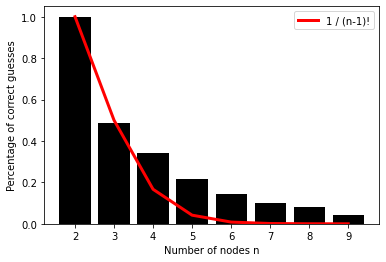

In [22]:
## Graphs bar plot for user to interpret
x = np.arange(2,n+2)
accuracy = freq / trials

xvals = np.array([np.math.factorial(i) for i in range(1,n+1)])
model = 1/xvals

plt.bar(x, accuracy, color='k')
plt.plot(x, model, color='r', linewidth=3, label="1 / (n-1)!")
plt.xlabel("Number of nodes n")
plt.ylabel("Percentage of correct guesses")
plt.legend()
plt.savefig("tsp_nn_correctness.png")
plt.plot()
